In [23]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

import itertools
from collections import OrderedDict
from tqdm import tqdm_notebook, tqdm
from scipy import stats

%matplotlib inline

# Most Influential Artists (Highest Out-Degree in AllMusic Graph)

In [17]:
# Load artist information
artists = pd.read_csv('data/allmusic/artists_cleaned.csv')
# Load influence relationships
influences = pd.read_csv('data/allmusic/influences_cleaned.csv')

In [18]:
artists.head()

,name,url,active_period,genres,styles,id,main_genre
0,Björk,https://www.allmusic.com/artist/bj%C3%B6rk-mn0...,1970s - 2010s,Pop/Rock|Electronic,Alternative/Indie Rock|Experimental Rock|Alter...,769444,Pop/Rock
1,Brigitte Fontaine,https://www.allmusic.com/artist/brigitte-fonta...,1970s - 2000s,Pop/Rock|International,Experimental|French Pop|French|Western Europea...,936658,Pop/Rock
2,Kate Bush,https://www.allmusic.com/artist/kate-bush-mn00...,1970s - 2010s,Pop/Rock,Art Rock|Alternative/Indie Rock|College Rock|A...,855423,Pop/Rock
3,Nina Hagen,https://www.allmusic.com/artist/nina-hagen-mn0...,1970s - 2010s,Pop/Rock,Alternative Pop/Rock|Alternative/Indie Rock|Ne...,414016,Pop/Rock
4,Zeena Parkins,https://www.allmusic.com/artist/zeena-parkins-...,1980s - 2010s,Avant-Garde|Jazz,Free Improvisation|Modern Composition,598083,Avant-Garde


In [19]:
# Create directed graph from influence relationships
G = nx.DiGraph()
# Create another DiGraph based on id
influence_graph_id = nx.DiGraph()

for row in influences.itertuples():
    G.add_edge(row.influencer_name, row.follower_name)
    influence_graph_id.add_edge(int(row.influencer_id), int(row.follower_id))

In [20]:
# Save influence graph (with id nodes) to file
nx.write_multiline_adjlist(influence_graph_id, 'networks/allmusic_influence_graph.txt')

In [21]:
# Create fields for indegree and outdegree
artists['indegree'] = artists['id'].apply(lambda x: influence_graph_id.in_degree(int(x)))
artists['outdegree'] = artists['id'].apply(lambda x: influence_graph_id.out_degree(int(x)))

In [22]:
# Write to csv
artists.to_csv('data/allmusic/artists_cleaned.csv', index=False)

In [25]:
# Summary of AllMusic Graph
print nx.info(influence_graph_id)

Name: 
Type: DiGraph
Number of nodes: 16704
Number of edges: 93065
Average in degree:   5.5714
Average out degree:   5.5714


In [26]:
# Find nodes with highest outdegree
outdegree_dict = G.out_degree()

# Pretty print artists with highest outdegree
for i, artist_tuple in enumerate(sorted(outdegree_dict.items(), key=lambda x: x[1], reverse=True)[:25]):
    print str(i+1) + '.', artist_tuple[0], artist_tuple[1]

1. The Beatles 911
2. Bob Dylan 558
3. The Rolling Stones 463
4. David Bowie 358
5. The Velvet Underground 356
6. Jimi Hendrix 308
7. The Beach Boys 306
8. The Kinks 306
9. Led Zeppelin 291
10. Neil Young 269
11. Miles Davis 266
12. James Brown 260
13. The Byrds 259
14. Black Sabbath 245
15. John Coltrane 244
16. Hank Williams 243
17. The Stooges 241
18. Brian Eno 237
19. The Who 230
20. Pink Floyd 227
21. Ramones 225
22. The Clash 224
23. Kraftwerk 222
24. Elvis Presley 222
25. Sex Pistols 220


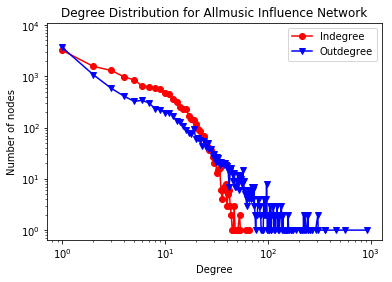

In [27]:
# Visualize degree distributions
in_degrees = influence_graph_id.in_degree() 
in_values = sorted(set(in_degrees.values()))
in_hist = [in_degrees.values().count(x) for x in in_values]

out_degrees = influence_graph_id.out_degree() 
out_values = sorted(set(out_degrees.values()))
out_hist = [out_degrees.values().count(x) for x in out_values]

plt.loglog(in_values,in_hist,'ro-') # indegree
plt.loglog(out_values,out_hist,'bv-') # outdegree
plt.legend(['Indegree','Outdegree'])
plt.xlabel('Degree')
plt.ylabel('Number of nodes')
plt.title('Degree Distribution for Allmusic Influence Network')

In [28]:
# Create set of all artists from Allmusic
allmusic_artists = set(pd.unique(artists['name']))

# SecondHandSongs Covers

In [31]:
# Load data
covers = pd.read_csv('data/secondhandsongs/covers.csv')

In [32]:
covers.head()

,work_id,work,adapted_work_id,adapted_work,performance_id,performance,performer_id,performer,artist_ids,artists,release_date,performance_date
0,1,Petite fleur,1,Petite fleur,1,Petite fleur,1.0,Sidney Bechet,1,Sidney Bechet,1952,1952-01-21
1,1,Petite fleur,1,Petite fleur,2,Petite fleur,3.0,Chris Barber's Jazz Band,113638,Chris Barber Band,1959,NaN
2,1,Petite fleur,1,Petite fleur,39127,Petite fleur,494.0,Charlie Byrd,494,Charlie Byrd,2000-03-14,NaN
3,1,Petite fleur,1,Petite fleur,40915,Petite fleur,12897.0,Laurindo Almeida & The Bossa Nova Allstars,12898,Laurindo Almeida,1962,NaN
4,1,Petite fleur,1,Petite fleur,66022,Petite fleur,27422.0,"Bart Voet, Louis Debij, Sam Vloemans, Esmé Bos...","31845, 31849, 31846, 31847, 31848","Bart Voet, Gulli Gudmundsson, Louis Debij, Sam...",2001,NaN


In [33]:
# Drop any rows with missing performer, release_date, artists
covers = covers.dropna(subset=['release_date', 'performer', 'artists'])

In [34]:
print "Number of covers:", len(covers)

Number of covers: 644786


In [35]:
# Basic summary statistics for number of covers per original work
covers.groupby('adapted_work_id').count()['work'].describe()

count    86827.00000
mean         7.42610
std         25.23396
min          1.00000
25%          2.00000
50%          2.00000
75%          5.00000
max       2004.00000
Name: work, dtype: float64

## What percentage of AllMusic artists are covered by artists in SecondHandSongs?
Note that this is using exact string matching. We may want to explore alternative methods for matching nodes between the two datasets.

In [15]:
# Get a list of all unique artists from SecondHandSongs
shs_artists = []

for artist_string in tqdm(covers['artists'].dropna().tolist()):
    # Sometimes there are multiple artists, so split on comma
    try:
        artists = [artist.strip() for artist in artist_string.split(',')]
    except:
        print artist_string
    
    for artist in artists:
        if artist not in shs_artists:
            shs_artists.append(artist)

shs_artists = set(shs_artists)


100%|██████████| 644786/644786 [02:39<00:00, 4040.58it/s]


In [16]:
shared_artist_count = len(allmusic_artists.intersection(shs_artists))
    
print "Percentage of Allmusic artists in SHS artists:", shared_artist_count / float(len(allmusic_artists))
print "Number of Allmusic artists", len(allmusic_artists)
print "Number of SHS artists", len(shs_artists)
# TODO: Perhaps account for unicode escaping issue?

Percentage of Allmusic artists in SHS artists: 0.572430207127
Number of Allmusic artists 15546
Number of SHS artists 77328


# Build up a network based on cover song data

In [36]:
# Group by work id, sorting by year within each group, filtering for groups larger than just 1 version
grouped_by_id = covers.sort_values('release_date').groupby('adapted_work_id').filter(lambda x: len(x) > 1)
grouped_by_id = grouped_by_id.sort_values('release_date').groupby('adapted_work_id')

In [25]:
# Create graph from cover songs, drawing a directed edge from each person in the cover chain
# to the next artist that covered the song chronologically
cover_graph = nx.DiGraph()

for song, song_cover_df in tqdm_notebook(grouped_by_id):
    # Get chronological series of artists that covered the song
    artists_series = song_cover_df['artists'].tolist()
    
    for i, artist in enumerate(artists_series):
        if i < len(artists_series) - 1:
            # Create lists splitting on commas since there can be multiple artists
            current_artists = artists_series[i].split(', ')
            successor_artists = artists_series[i + 1].split(', ')
            
            for current_artist in current_artists:
                for succesor_artist in successor_artists:
                    cover_graph.add_edge(current_artist, succesor_artist)

A Jupyter Widget

In [20]:
# Basic summary statistics
print nx.info(cover_graph)
print "Number weakly connected components:", nx.number_weakly_connected_components(cover_graph)

Name: 
Type: DiGraph
Number of nodes: 76596
Number of edges: 664724
Average in degree:   8.6783
Average out degree:   8.6783
Number weakly connected components: 1350


In [21]:
# Find nodes with highest outdegree
cover_outdegree_dict = cover_graph.out_degree()
# Display 100 nodes with highest outdegree
sorted(cover_outdegree_dict.items(), key=lambda x: x[1], reverse=True)[:100]

[('Top of the Pops', 792),
 ('Ella Fitzgerald', 586),
 ('Willie Nelson', 575),
 ('Frank Sinatra', 561),
 ('Elvis Presley', 517),
 ('Ray Conniff', 508),
 ('Johnny Mathis', 501),
 ('Tony Bennett', 485),
 ('Geoff Love', 474),
 ('Bing Crosby', 455),
 ('Oscar Peterson', 447),
 ('Ray Brown', 443),
 ('Peggy Lee', 426),
 ('Sarah Vaughan', 426),
 ('Johnny Cash', 422),
 ('George Shearing', 420),
 ('Cliff Richard', 410),
 ('Rosemary Clooney', 399),
 ('Mel Torm\xc3\xa9', 392),
 ('John Pizzarelli', 391),
 ('Bucky Pizzarelli', 384),
 ('Hank Jones', 384),
 ('Kenny Barron', 382),
 ('James Last', 381),
 ('The Jordanaires', 381),
 ('Jerry Lee Lewis', 373),
 ('Andy Williams', 372),
 ('Joe Pass', 369),
 ('Bob Dylan', 368),
 ('St\xc3\xa9phane Grappelli', 365),
 ('Percy Faith', 353),
 ('Keith Ingham', 350),
 ('Carmen McRae', 350),
 ('Vitamin String Quartet', 347),
 ('Nancy Wilson', 346),
 ('Dave McKenna', 345),
 ('Pat Boone', 345),
 ('Sammy Davis Jr.', 343),
 ('Chet Atkins', 341),
 ('Beegie Adair', 338),
 (

# Most Covered Songs

In [22]:
# Sort groups of covers by number of covers in each group in descending order
grouped_by_id_sorted = sorted(grouped_by_id, key=lambda x: len(x[1]), reverse=True)

In [23]:
# Print top 25 most covered songs with their count of samples
for i in range(25):
    print str(i + 1) + '.', grouped_by_id_sorted[i][1]['adapted_work'].iloc[0], grouped_by_id_sorted[i][1]['adapted_work'].count()

1. Silent Night! Holy Night! 2004
2. Summertime 1611
3. Away in a Manger [Mueller] 1536
4. O, Holy Night 1304
5. New Britain 858
6. White Christmas 828
7. Have Yourself a Merry Little Christmas 825
8. O Come, All Ye Faithful 808
9. Can't Help Falling in Love 804
10. The Christmas Song (Merry Christmas to You) 761
11. Over the Rainbow 709
12. Body and Soul 707
13. What Child Is This? 664
14. Winter Wonderland 615
15. God Rest You Merry, Gentlemen 612
16. Jingle Bells 608
17. The First Nowell the Angel Did Say 605
18. My Funny Valentine 579
19. Stille Nacht! Heilige Nacht! 545
20. Yesterday 538
21. I'll Be Home for Christmas (If Only in My Dreams) 538
22. Carol of the Drum 534
23. Joy to the World 531
24. St. Louis Blues 521
25. Love Me Tender 520


In [24]:
# Plot cumulative number of covers over time of an input series of release dates
def plot_covers_by_year(dates_series, title):
    # Extract year
    list_of_dates = dates_series.map(lambda x: int(x.split('-')[0]))
    counts = np.arange(0, len(list_of_dates))
    plt.plot(list_of_dates, counts)
    try:
        plt.title(title)
    except:
        pass
    plt.xlabel('Year')
    plt.ylabel('Total Number of Covers')
    plt.show()

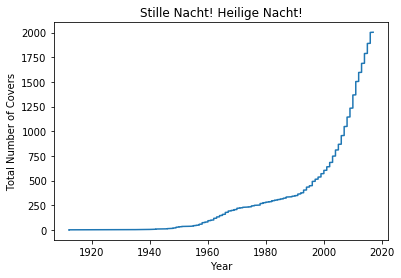

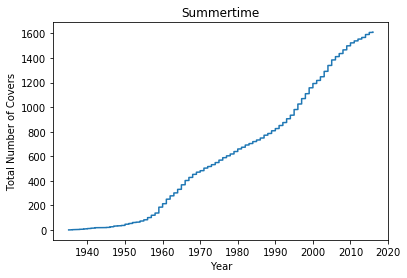

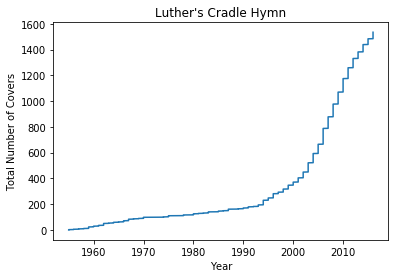

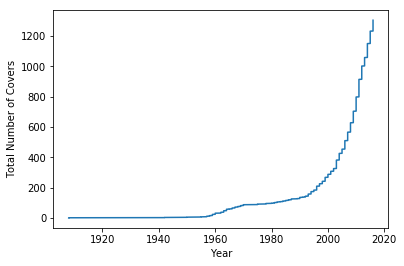

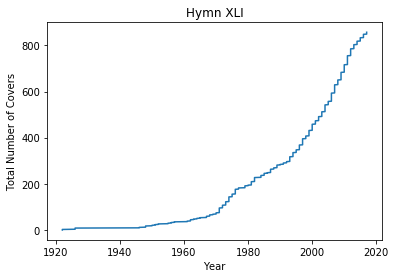

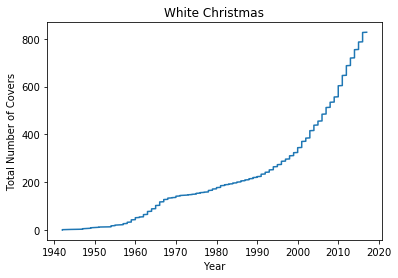

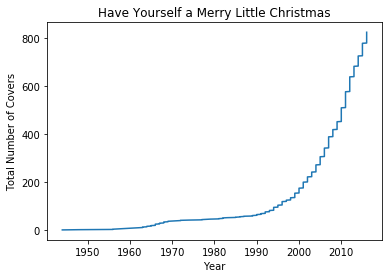

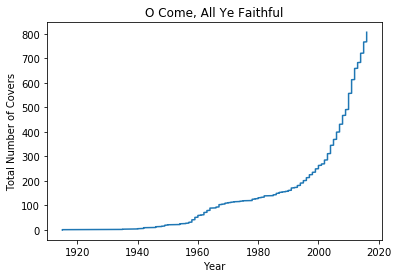

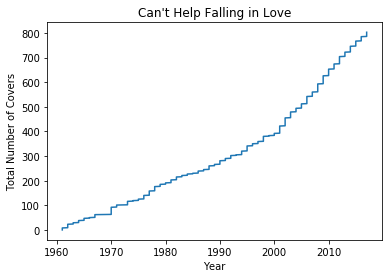

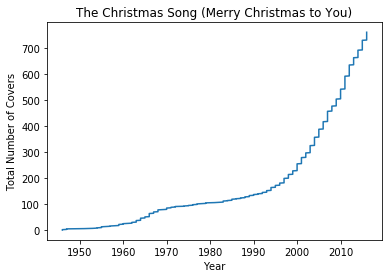

In [25]:
# Plot number of covers by year for top 10 most covered songs
for i in range(10):
    plot_covers_by_year(grouped_by_id_sorted[i][1]['release_date'], grouped_by_id_sorted[i][1]['work'].iloc[0])

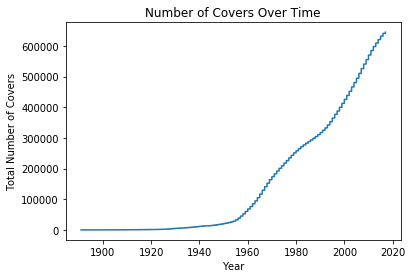

In [26]:
# Plot number of covers by year over all songs
plot_covers_by_year(covers.sort_values('release_date')['release_date'], "Number of Covers Over Time")

# Most Covered Artists

In [27]:
# Return counts per artist of number of songs where they were the original artist
Counter(grouped_by_id.first()['performer']).most_common()

# TODO: Overlap with AllMusic

[('ApologetiX', 308),
 ('Bob Dylan', 225),
 ('Claude Fran\xc3\xa7ois', 155),
 ('Johnny Hallyday', 155),
 ('David Bowie', 147),
 ('Bruce Springsteen', 144),
 ('Tom Waits', 143),
 ('Raga Rockers', 137),
 ('Eddy Mitchell', 134),
 ('Will Tura', 130),
 ('Elvis Presley with The Jordanaires', 130),
 ('Dalida', 128),
 ('Ramones', 128),
 ('Richard Anthony', 117),
 ('Depeche Mode', 117),
 ('Stevie Wonder', 114),
 ('The Kinks', 114),
 ('Benny Neyman', 114),
 ('Peter Belli', 113),
 ('Elvis Presley', 108),
 ('Pink Floyd', 104),
 ('The Beach Boys', 104),
 ('The Beatles', 103),
 ('The Rolling Stones', 99),
 ('Kiss', 97),
 ('Joni Mitchell', 93),
 ('Genesis', 92),
 ('The Who', 90),
 ('Jacques Brel', 90),
 ('Johnny Cash', 90),
 ('Vazelina Bilopph\xc3\xb8ggers', 85),
 ('Fabrizio De Andr\xc3\xa9', 83),
 ('The Cure', 81),
 ('Jimmie Rodgers', 81),
 ('De La Soul', 81),
 ('Joe Dassin', 80),
 ('Die Schl\xc3\xbcmpfe', 79),
 ('Queen', 78),
 ('Nana Mouskouri', 77),
 ('Frank Zappa', 77),
 ('"Weird Al" Yankovic', 7

# Distribution of Time in Years Between Covers

In [28]:
# List of year gaps between covers
year_gaps = []

for song, song_cover_df in tqdm(grouped_by_id):
    dates = song_cover_df['release_date'].tolist()
    
    for i, date in enumerate(dates):
        if i < len(dates) - 1:
            year_gaps.append(int(dates[i+1].split('-')[0]) - int(dates[i].split('-')[0]))

100%|██████████| 86827/86827 [00:19<00:00, 4533.39it/s]


In [29]:
pd.Series(year_gaps).describe()

count    557959.000000
mean          3.113232
std           7.095117
min           0.000000
25%           0.000000
50%           1.000000
75%           2.000000
max         104.000000
dtype: float64

# Overlap Between SecondHandSongs and AllMusic Edges
## Assumption: we draw directed edges between every ancestor in a sequence of cover versions and later versions.

In [30]:
overlap_count = 0
total_count = 0

allmusic_edges_set = set(G.edges())

for song, song_cover_df in tqdm_notebook(grouped_by_id):
    # Get chronological series of artists that covered the song
    artists_series = song_cover_df['artists'].tolist()
    
    for j, artist in enumerate(artists_series):
        for i in range(j):
            # Create lists splitting on commas since there can be multiple artists
            current_artists = artists_series[i].split(', ')
            successor_artists = artists_series[j].split(', ')
            
            for current_artist in current_artists:
                for successor_artist in successor_artists:
                    if (current_artist, successor_artist) in allmusic_edges_set:
                        overlap_count +=1
                        # Remove from set so we can see what edges are not in the overlap at the end
                        allmusic_edges_set.discard((current_artist, successor_artist))
                        
                    total_count += 1

print "Edge overlap percentage:", overlap_count / float(len(G.edges()))
print "Number in overlap:", overlap_count
print "Number missed:", len(G.edges()) - overlap_count

A Jupyter Widget


Edge overlap percentage: 0.167872150634
Number in overlap: 15620
Number missed: 77427


In [31]:
# Compute number of times an ancestral relationship in the cover songs dataset is found 
# in the AllMusic Influence Graph (Duplicates allowed)
overlap_count_with_duplicates = 0
total_count = 0
# Create counter for ancestral relationships, keyed by edge
ancestry_counter = Counter()

allmusic_edges = set(G.edges())

for song, song_cover_df in tqdm_notebook(grouped_by_id):
    # Get chronological series of artists that covered the song
    artists_series = song_cover_df['artists'].tolist()
    
    for j, artist in enumerate(artists_series):
        for i in range(j):
            # Create lists splitting on commas since there can be multiple artists
            current_artists = artists_series[i].split(', ')
            successor_artists = artists_series[j].split(', ')
            
            for current_artist in current_artists:
                for successor_artist in successor_artists:
                    if (current_artist, successor_artist) in allmusic_edges:
                        ancestry_counter[(current_artist, successor_artist)] += 1
                        overlap_count_with_duplicates +=1
                        
                    total_count += 1

print "Number of hits on AllMusic edges (Duplicates Allowed):", overlap_count_with_duplicates

A Jupyter Widget


Number of hits on AllMusic edges (Duplicates Allowed): 101622


## Including Collaborator Relationships

In [32]:
overlap_count = 0
allmusic_edges_set = set(G.edges())

for song, song_cover_df in tqdm_notebook(grouped_by_id):
    # Get chronological series of artist lists that covered the song
    artists_series = song_cover_df['artists'].tolist()
    
    for j, artist in enumerate(artists_series):
        successor_artists = artists_series[j].split(', ')
        
        # Create all possible permutations for collaborators on a single version as possible edges
        if len(successor_artists) > 1: 
            collaborator_permutations = itertools.permutations(successor_artists, 2)
            
            for pair in collaborator_permutations:
                if pair in allmusic_edges_set:
                    print pair
                    overlap_count +=1
                    # Remove from set so we can see what edges are not in the overlap at the end
                    allmusic_edges_set.discard(pair)

        for i in range(j):
            # Create lists splitting on commas since there can be multiple artists
            current_artists = artists_series[i].split(', ')
            
            for current_artist in current_artists:
                for successor_artist in successor_artists:
                    if (current_artist, successor_artist) in allmusic_edges_set:
                        overlap_count +=1
                        # Remove from set so we can see what edges are not in the overlap at the end
                        allmusic_edges_set.discard((current_artist, successor_artist))
                    
        # Also update overlap count if collaborator relationship is in the AllMusic set
           
                        
print "Edge overlap percentage (collaborator relationships included):", overlap_count / float(len(G.edges()))
print "Number in overlap:", overlap_count
print "Number missed:", len(G.edges()) - overlap_count

A Jupyter Widget

('The Chieftains', 'Van Morrison')
("Screamin' Jay Hawkins", 'The Fuzztones')
('Larry Carlton', 'Robben Ford')
('Bob Andy', 'Marcia Griffiths')
('Roger McGuinn', 'Judy Collins')
('Chet Atkins', 'Jerry Reed')
('Nico', 'Bauhaus')
('Bill Frisell', 'Petra Haden')
('Andrea Bocelli', 'Katharine McPhee')
('Steve Vai', 'John Petrucci')
('Joe Satriani', 'Steve Vai')
('Joe Satriani', 'John Petrucci')
('Bob Dylan', 'Grateful Dead')
('Hank Jones', 'Elvin Jones')
('Duane Eddy', 'The Art of Noise')
('Tommy Dorsey', 'Frank Sinatra')
('Taj Mahal', 'Eric Bibb')
('Celia Cruz', 'Tito Nieves')
('Celia Cruz', 'Tony Vega')
('Lee Hazlewood', 'Nancy Sinatra')
('Lydia Lunch', 'Die Haut')
('David Bowie', 'Arcade Fire')
('The Notorious B.I.G.', 'Mase')
('Puff Daddy', 'Mase')
('Ronnie Hawkins', 'The Band')
('Bo Diddley', 'Ron Wood')
('Moby', 'Sean Lennon')
('Graham Parker', 'The Figgs')
('Dave McKenna', 'Scott Hamilton')
('Tom Jones', 'Robbie Williams')
('Dr. John', 'The Dirty Dozen Brass Band')
('Roberta Flack',

('Vic Chesnutt', 'M. Ward')
('Al Kooper', 'Shuggie Otis')
('Fat Joe', 'Jennifer Lopez')
('Merle Travis', 'Joe Maphis')
('Mary J. Blige', "Lil' Kim")
('John Lee Hooker', 'Bonnie Raitt')
('Chuck Berry', 'Robert Cray')
('Kris Kristofferson', 'Shooter Jennings')
('Pat Martino', 'Charlie Hunter')
('Rufus Thomas', 'Carla Thomas')
('Roy Clark', 'Ricky Skaggs')
('Waylon Jennings', 'Trick Pony')
('Johnny Cash', 'Trick Pony')
('Paul McCartney', 'Michael Jackson')
('Arthur Blythe', 'Chico Freeman')
('Eddie Palmieri', 'Brian Lynch')
('Biz Markie', 'Beastie Boys')
('Patsy Cline', 'Dolly Parton')
('Jackson Browne', 'Kathy Mattea')
('Merle Haggard', 'Jamey Johnson')
('Carly Simon', 'Ben Taylor')
('Lee Hazlewood', 'Duane Eddy')
('Fred Astaire', 'Judy Garland')
('George Jones', 'Marty Stuart')
('Willie Nelson', 'Trick Pony')
('Peter Tosh', 'Mick Jagger')
('Mac Wiseman', 'Del McCoury')
('Serge Gainsbourg', 'Charlotte Gainsbourg')
('Luther Vandross', 'Mariah Carey')
('The Dubliners', 'Rory Gallagher')
('

# Compute Edge Overlap Only Considering Edges Consisting of Overlapping Nodes between the 2 datasets
Since only about 60% of the nodes in the AllMusic dataset are covered by nodes in the SecondHandSongs dataset, let's see what the edge overlap percentage is when we only consider edges from AllMusic where both of the nodes belong to the node overlap between the two datasets

In [33]:
# Create set of node intersection between AllMusic and SecondHandSongs sets
intersection_artists = allmusic_artists.intersection(shs_artists)
# Filter for edges where both nodes are contained within the node intersection of the two datasets
allmusic_edges_filtered = set([edge for edge in G.edges() if edge[0] in intersection_artists and edge[1] in intersection_artists])

In [34]:
overlap_count = 0

allmusic_edges_set = set(G.edges())

for song, song_cover_df in tqdm_notebook(grouped_by_id):
    # Get chronological series of artists that covered the song
    artists_series = song_cover_df['artists'].tolist()
    
    for j, artist in enumerate(artists_series):
        for i in range(j):
            # Create lists splitting on commas since there can be multiple artists
            current_artists = artists_series[i].split(', ')
            successor_artists = artists_series[j].split(', ')
            
            for current_artist in current_artists:
                for successor_artist in successor_artists:
                    if (current_artist, successor_artist) in allmusic_edges_set:
                        overlap_count +=1
                        # Remove from set so we can see what edges are not in the overlap at the end
                        allmusic_edges_set.discard((current_artist, successor_artist))
                        
print "Edge overlap percentage:", overlap_count / float(len(allmusic_edges_filtered))
print "Number in overlap:", overlap_count

A Jupyter Widget


Edge overlap percentage: 0.26159334126
Number in overlap: 15620


# Weaker Assumption: Overlap when we only consider the parent in cover chain

In [35]:
overlap_count = 0
total_count = 0

allmusic_edges_set = set(G.edges())

for song, song_cover_df in tqdm_notebook(grouped_by_id):
    # Get chronological series of artists that covered the song
    artists_series = song_cover_df['artists'].tolist()
    
    for i, artist in enumerate(artists_series):
        if i < len(artists_series) - 1:
            # Create lists splitting on commas since there can be multiple artists
            current_artists = artists_series[i].split(', ')
            successor_artists = artists_series[i + 1].split(', ')
            
            for current_artist in current_artists:
                for successor_artist in successor_artists:
                    if (current_artist, successor_artist) in allmusic_edges_set:
                        overlap_count +=1
                        # Remove from set so we can see what edges are not in the overlap at the end
                        allmusic_edges_set.discard((current_artist, successor_artist))
                        
                    total_count += 1

print "Edge overlap percentage (immediate parent in cover chain only):", overlap_count / float(len(G.edges()))
print "Number in overlap:", overlap_count
print "Number missed:", len(G.edges()) - overlap_count

A Jupyter Widget


Edge overlap percentage (immediate parent in cover chain only): 0.0346706503165
Number in overlap: 3226
Number missed: 89821


# Weaker Assumption: Overlap when we only consider the first song in the chain as a possible parent

In [36]:
overlap_count = 0
total_count = 0

allmusic_edges_set = set(G.edges())

for song, song_cover_df in tqdm_notebook(grouped_by_id):
    # Get chronological series of artists that covered the song
    artists_series = song_cover_df['artists'].tolist()
    
    for i, artist in enumerate(artists_series):
            # Create lists splitting on commas since there can be multiple artists
            current_artists = artists_series[0].split(', ')
            successor_artists = artists_series[i].split(', ')
            
            for current_artist in current_artists:
                for successor_artist in successor_artists:
                    if (current_artist, successor_artist) in allmusic_edges_set:
                        overlap_count +=1
                        # Remove from set so we can see what edges are not in the overlap at the end
                        allmusic_edges_set.discard((current_artist, successor_artist))
                        
                    total_count += 1

print "Edge overlap percentage (only first artist is parent):", overlap_count / float(len(G.edges()))
print "Number in overlap:", overlap_count
print "Number missed:", len(G.edges()) - overlap_count

A Jupyter Widget


Edge overlap percentage (only first artist is parent): 0.0744892366224
Number in overlap: 6931
Number missed: 86116
